<a href="https://colab.research.google.com/github/ronniemi/deep_learning/blob/master/assignment_1_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import pandas as pd
import numpy as np
import random
from os import listdir
from os.path import join
import pickle

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns

from skimage.transform import resize

from keras.models import Model, Sequential, model_from_json
from keras.layers import Dense, Conv2D, Flatten, Input, AvgPool2D, MaxPool2D, Dropout, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras import callbacks
from scipy import misc

from keras.applications.vgg16 import VGG16

from keras.datasets import cifar10

In [0]:
# read the data

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [0]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [0]:
# normalise and center the mean using mean and std of ImageNet data set


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def normalization(x):
  x = x.astype('float32')
  x = x/255
  x[..., 0] -= mean[0]
  x[..., 1] -= mean[1]
  x[..., 2] -= mean[2]
  x[..., 0] /= std[0]
  x[..., 1] /= std[1]
  x[..., 2] /= std[2]
  return x

x_train = normalization(x_train)
x_test = normalization(x_test)

In [0]:
# load VGG16 pre-trained model- fits input shape to cifar10 images size

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

In [0]:
# Extract the last layer from fifth block of vgg16 model

last = base_model.get_layer('block5_pool').output

In [0]:
# Add classification layers on top of it

x = Flatten()(last)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
pred = Dense(10, activation='softmax')(x)

In [0]:
# difine the model

model = Model(base_model.input, pred)

In [9]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=1e-3, momentum=0.9), metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0         
__________

In [10]:
# fine-tune the model

history = model.fit(x_train, y_train, epochs=5, validation_split=0.2, shuffle=True)

Train on 40000 samples, validate on 10000 samples
Epoch 1/5
40000/40000 [==============================] - 130s 3ms/step - loss: 1.2344 - acc: 0.5663 - val_loss: 0.9336 - val_acc: 0.6798
Epoch 2/5
40000/40000 [==============================] - 126s 3ms/step - loss: 0.6425 - acc: 0.7831 - val_loss: 0.5490 - val_acc: 0.8160
Epoch 3/5
40000/40000 [==============================] - 125s 3ms/step - loss: 0.4792 - acc: 0.8376 - val_loss: 0.5565 - val_acc: 0.8129
Epoch 4/5
40000/40000 [==============================] - 126s 3ms/step - loss: 0.3559 - acc: 0.8785 - val_loss: 0.4936 - val_acc: 0.8316
Epoch 5/5
40000/40000 [==============================] - 126s 3ms/step - loss: 0.2721 - acc: 0.9077 - val_loss: 0.4926 - val_acc: 0.8427



[[880   4   5   9   3   0   0  13  64  22]
 [ 17 876   1   1   0   2   1   3  16  83]
 [ 76   1 693  63  53  43  22  32  14   3]
 [ 14   3  11 712  23 152  22  44  12   7]
 [ 16   1  23  54 760  43  12  80   8   3]
 [  5   2  10 116  16 802   3  43   1   2]
 [  4   3  15  68  22  26 833  15   8   6]
 [  7   1   2  18  11  33   0 926   1   1]
 [ 23   4   0   5   0   1   0   2 953  12]
 [ 10  27   2   7   1   4   1  11  25 912]]

model accuracy on test set is: 83.47%


Text(0.5,1,'CIFAR-10 Convolutional model \n classification results on test set')

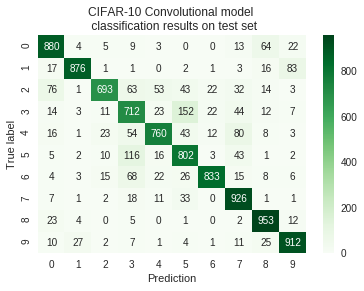

In [11]:
 # accuracy on test set

y_test_cat = np.argmax(y_test, axis=1)
preds = model.predict(x_test)
pred_cat = np.argmax(preds, axis=1)
print('')
print(confusion_matrix(y_test_cat, pred_cat))
print()
print('model accuracy on test set is: {}%'.format(accuracy_score(y_test_cat, pred_cat)*100))
sns.heatmap(confusion_matrix(y_test_cat, pred_cat), cmap='Greens', annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('CIFAR-10 Convolutional model \n classification results on test set')


[[4730    8   15   18    7    4    1   25  156   36]
 [  20 4719    1    6    0    1    5    9   56  183]
 [ 211    1 4284  155   93  108   46   72   26    4]
 [  14    2   19 4260   42  500   28  110   17    8]
 [  51    0   49  141 4293  131   11  300   18    6]
 [   5    2   16  348   20 4455   10  140    2    2]
 [  14    2   20  176   60   82 4567   53   15   11]
 [  14    1    5   32   10   36    0 4897    3    2]
 [  36    7    4    9    0    4    3    2 4922   13]
 [  16   39    2   16    1    7    1   17   32 4869]]

model accuracy on test set is: 91.99199999999999%


Text(0.5,1,'CIFAR-10 Convolutional model \n classification results on test set')

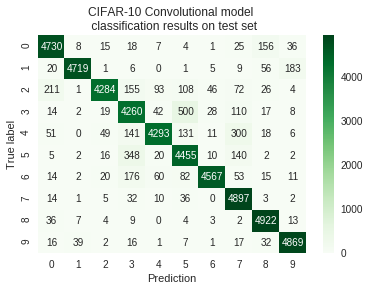

In [12]:
 # accuracy on train set

y_train_cat = np.argmax(y_train, axis=1)
preds = model.predict(x_train)
pred_cat = np.argmax(preds, axis=1)
print('')
print(confusion_matrix(y_train_cat, pred_cat))
print()
print('model accuracy on test set is: {}%'.format(accuracy_score(y_train_cat, pred_cat)*100))
sns.heatmap(confusion_matrix(y_train_cat, pred_cat), cmap='Greens', annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('CIFAR-10 Convolutional model \n classification results on test set')

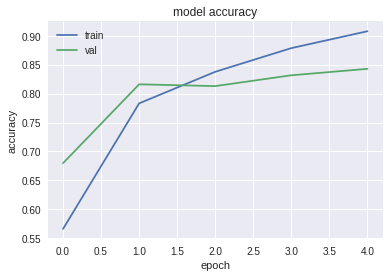

In [13]:
# plotting accuracy train-test

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

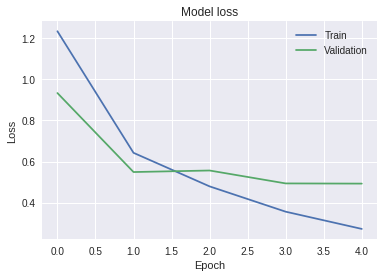

In [14]:
# plotting loss function

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [15]:
# to make the folders in my drive Accessibe

from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# helper function to load and save the model for use as feature extractor

models_path = '/content/drive/My Drive/deep learning/models' # change the path to your preference

# this is a helper function used to save a keras NN model architecture and weights
def save_model(model,filename):
    json_string = model.to_json()
    path = join(models_path, filename)
    open(path + '_architecture.json', 'w').write(json_string)
    model.save_weights(path + '_model_weights.h5', overwrite=True)
    
# this is a helper function used to restore a keras NN model architecture and weights
def read_model(filename):
    path = join(models_path, filename)
    model = model_from_json(open(path + '_architecture.json', 'r').read())
    model.load_weights(path + '_model_weights.h5')
    return model

In [0]:
# save the model

save_model(model, 'fine_tuning_1911')